# Visualize the Optimization Process

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

## Datasets

### MNIST

In [2]:
# The training data
mnist_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# The testing data
mnist_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
def get_train_dataloader(batch_size):
    mnist_train_dataloader = DataLoader(
        mnist_training_data, batch_size=batch_size, shuffle=True
    )
    return mnist_train_dataloader


def get_test_dataloader(batch_size):
    mnist_test_dataloader = DataLoader(mnist_test_data, batch_size=batch_size)
    return mnist_test_dataloader

## Training & Testing Functions

In [4]:
def train(args, model, train_loader, loss_func, optimizer, epoch):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()

        if batch_idx % args["log_interval"] == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAcc: {:.6f}%".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                    100 * correct / len(train_loader.dataset),
                )
            )
    if epoch % 3 == 0:
        weights = torch.cat([param.flatten() for param in model.parameters()])
        weights = weights.detach().numpy()
        return weights, 100 * correct / len(train_loader.dataset)
    return None, None

## Model

In [5]:
class Dnn(nn.Module):
    def __init__(self):
        super(Dnn, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 1000)
        self.fc2 = nn.Linear(1000, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
args = {
    "log_interval": 200,
    "lr": 1e-4,
    "epochs": 24,
    "batch_size": [64, 128, 256, 512, 750, 1024, 1500, 2048],
}

In [7]:
points_list = []
acc_list = []
pca = PCA(n_components=2)

for idx in range(8):
    print(str(idx + 1) + " time")
    train_dataloader = get_train_dataloader(args["batch_size"][idx])
    model = Dnn()
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=args["lr"])
    weights_per_epoch = []
    acc_per_epoch = []
    for epoch in range(1, args["epochs"] + 1):
        weights, acc = train(args, model, train_dataloader, loss_func, optimizer, epoch)
        if weights is not None:
            weights_per_epoch.append(weights)
            acc_per_epoch.append(acc)
    points_list.append(pca.fit_transform(weights_per_epoch))
    acc_list.append(acc_per_epoch)

1 time
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304437	Acc: 0.011667%
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.728006	Acc: 14.901667%
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.466710	Acc: 33.493333%
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.434485	Acc: 52.618333%
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.352832	Acc: 71.968333%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.409373	Acc: 0.091667%
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.285150	Acc: 19.803333%
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.513297	Acc: 39.588333%
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.188743	Acc: 59.413333%
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.184278	Acc: 79.411667%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.093812	Acc: 0.105000%
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.109883	Acc: 20.193333%
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.120026	Acc: 40.303333%
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.080717	Acc: 60.365000%
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.087755	Acc: 80.601667%
Train Epoch: 4 [0/600

In [8]:
import pandas as pd

In [9]:
colors = ["red", "blue", "purple", "green", "yellow", "brown", "black", "grey"]

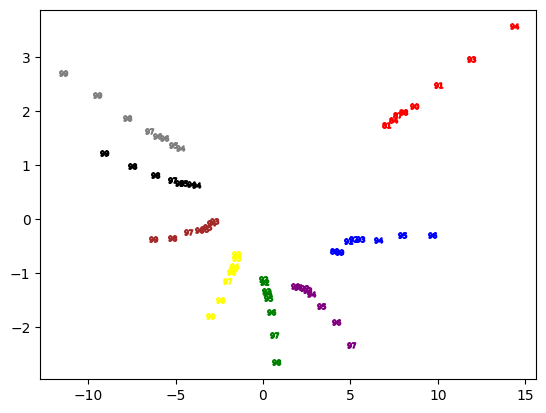

In [10]:
fig, ax = plt.subplots()
for points_per_model, acc_per_model in zip(points_list, acc_list):
    df = pd.DataFrame(points_per_model, columns=["x", "y"])
    df["acc"] = acc_per_model
    df["acc"] = df["acc"].astype("int").astype(str)
    for idx, row in df.iterrows():
        ax.scatter(row["x"], row["y"], marker=f'${row["acc"]}$', color=colors[idx])